# Optimal Learning Rate 찾기 및 Huber Loss 함수 적용

손실 함수는 크게 분류 및 회귀 손실의 두 가지 유형으로 분류 할 수 있습니다. Huber Loss는 회귀 손실에 속합니다. Huber 손실은 제곱 오차 손실보다 데이터의 이상 값에 덜 민감합니다. 

<img src="https://blog.kakaocdn.net/dn/081sh/btqNth1n6DL/rkSLdrV0RFuYg04k4VyeZK/img.png" width=300/>

$$L_{\delta}(y, f(x))= \begin{cases}
    \frac{1}{2}(y-f(x))^2       & \quad \text{ for |y-f(x)|} \leq \delta,\\
   \delta |y-f(x)|-\frac{1}{2} \delta^2  & \quad \text{if } n \text{ is odd}
  \end{cases}$$  
  
- Huber function은 모든 구간에서 미분가능하고 연속  
- $\delta$로 경사도 조절

### Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0) # 첫 줄은 header이므로 skip 
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


- 시간 절약을 위해 최근 500 개월치 data 만 이용

In [17]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

## Supervised Learning dataset 작성

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### train/validation set 분리

In [19]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [20]:
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [21]:
for x, y in train_ds:
    print('x = ', x.numpy().shape)
    print('y = ', y.numpy().shape)
    break

x =  (16, 20)
y =  (16,)


## Stacked + Bidirectoinal LSTM

In [22]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
    return model

### Optimal Learning Rate 찾기

- epoch이 진행되면서 Learning Rate를 증가시킴  

- loss가 감소하다 증가하는 경우 learning rate를 시각화 하여 loss 증가 직전의 가장 큰 learning rate 선택  

- 선택한 learning rate 로 다시 train

In [23]:
model = create_model()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler( 
                                        lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
27/27 [==============================] - 3s 7ms/step - loss: 96.2662 - mae: 96.7640 - lr: 1.0000e-08
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 95.5134 - mae: 96.0133 - lr: 1.1220e-08
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 94.6288 - mae: 95.1288 - lr: 1.2589e-08
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 93.6774 - mae: 94.1756 - lr: 1.4125e-08
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 92.6684 - mae: 93.1663 - lr: 1.5849e-08
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 91.6358 - mae: 92.1338 - lr: 1.7783e-08
Epoch 7/100
27/27 [==============================] - 0s 7ms/step - loss: 90.5517 - mae: 91.0503 - lr: 1.9953e-08
Epoch 8/100
27/27 [==============================] - 0s 7ms/step - loss: 89.4058 - mae: 89.9031 - lr: 2.2387e-08
Epoch 9/100
27/27 [==============================] - 0s 7ms/step - loss: 88.1623 - mae: 88.6586 

Epoch 73/100
27/27 [==============================] - 0s 8ms/step - loss: 39.2031 - mae: 39.7013 - lr: 3.9811e-05
Epoch 74/100
27/27 [==============================] - 0s 8ms/step - loss: 35.9088 - mae: 36.4043 - lr: 4.4668e-05
Epoch 75/100
27/27 [==============================] - 0s 8ms/step - loss: 35.5951 - mae: 36.0921 - lr: 5.0119e-05
Epoch 76/100
27/27 [==============================] - 0s 8ms/step - loss: 48.1962 - mae: 48.6919 - lr: 5.6234e-05
Epoch 77/100
27/27 [==============================] - 0s 8ms/step - loss: 36.8134 - mae: 37.3058 - lr: 6.3096e-05
Epoch 78/100
27/27 [==============================] - 0s 8ms/step - loss: 42.2049 - mae: 42.7021 - lr: 7.0795e-05
Epoch 79/100
27/27 [==============================] - 0s 8ms/step - loss: 50.7177 - mae: 51.2146 - lr: 7.9433e-05
Epoch 80/100
27/27 [==============================] - 0s 8ms/step - loss: 41.7047 - mae: 42.2019 - lr: 8.9125e-05
Epoch 81/100
27/27 [==============================] - 0s 8ms/step - loss: 51.6576 - mae:

- loss 시각화

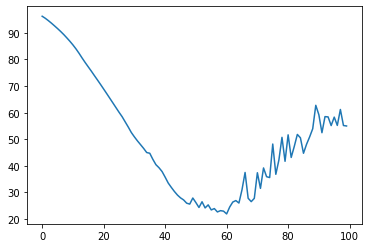

In [24]:
plt.plot(history.history['loss'])

### learning rate에 따른 loss 시각화 

x 축에 learning rate (`history.history['lr']`), y축에 `loss` 를 시각화  

plt.axis(xmin, xmax, ymin, ymax)

(1e-07, 0.0001, 20.0, 70.0)

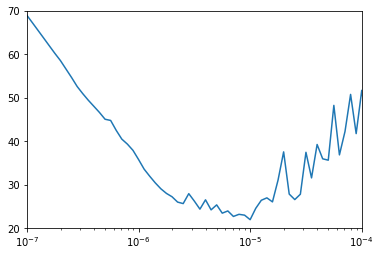

In [25]:
plt.semilogx(history.history['lr'], history.history['loss'])

plt.axis([1e-7, 1e-4, 20, 70])

In [26]:
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

best_lr = np.array(tuple(history.history['lr']))[idx]
best_lr

array([1.e-05], dtype=float32)

### model re-train

최적의 learning rate를 이용하여 model retrain

In [28]:
model = create_model()

optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100)

Epoch 1/100
27/27 [==============================] - 3s 8ms/step - loss: 49.6413 - mae: 50.1384
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 38.5029 - mae: 38.9987
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 30.7713 - mae: 31.2664
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 27.4267 - mae: 27.9196
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 25.9929 - mae: 26.4852
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 23.9078 - mae: 24.4013
Epoch 7/100
27/27 [==============================] - 0s 7ms/step - loss: 24.5035 - mae: 24.9981
Epoch 8/100
27/27 [==============================] - 0s 7ms/step - loss: 22.6733 - mae: 23.1682
Epoch 9/100
27/27 [==============================] - 0s 7ms/step - loss: 23.4586 - mae: 23.9521
Epoch 10/100
27/27 [==============================] - 0s 7ms/step - loss: 23.6165 - mae: 24.1077
Epoch 11/100
27/27 [===================

27/27 [==============================] - 0s 9ms/step - loss: 20.1478 - mae: 20.6417
Epoch 86/100
27/27 [==============================] - 0s 9ms/step - loss: 20.7217 - mae: 21.2104
Epoch 87/100
27/27 [==============================] - 0s 10ms/step - loss: 22.3186 - mae: 22.8152
Epoch 88/100
27/27 [==============================] - 0s 8ms/step - loss: 21.5457 - mae: 22.0379
Epoch 89/100
27/27 [==============================] - 0s 8ms/step - loss: 20.1365 - mae: 20.6309
Epoch 90/100
27/27 [==============================] - 0s 9ms/step - loss: 21.7233 - mae: 22.2149
Epoch 91/100
27/27 [==============================] - 0s 11ms/step - loss: 19.9006 - mae: 20.3948
Epoch 92/100
27/27 [==============================] - 0s 9ms/step - loss: 21.2576 - mae: 21.7513
Epoch 93/100
27/27 [==============================] - 0s 9ms/step - loss: 21.3772 - mae: 21.8705
Epoch 94/100
27/27 [==============================] - 0s 9ms/step - loss: 21.6288 - mae: 22.1229
Epoch 95/100
27/27 [=====================

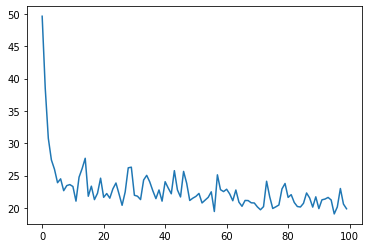

In [29]:
plt.plot(history.history['loss'])

In [30]:
forecast = []

for time in range(split_time, len(time_series)):
    prediction = model.predict(time_series[time-window_size: time].reshape(1, -1))
    forecast.append(prediction[0][0])
    
len(forecast)

50

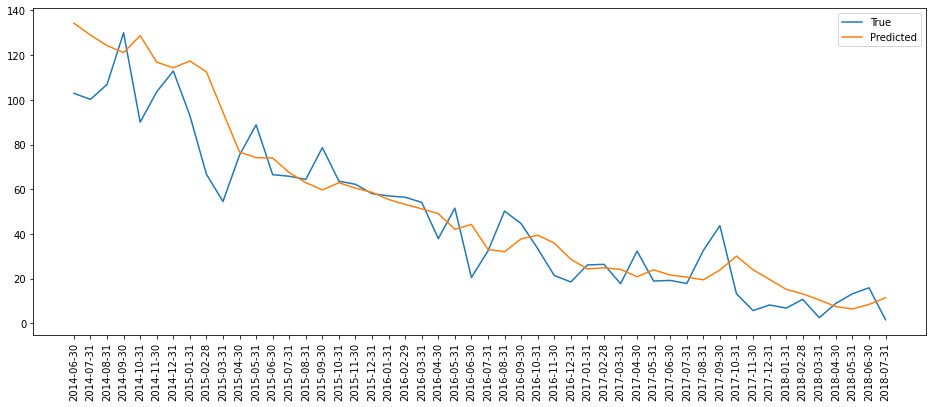

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test, forecast, label='Predicted')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [32]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

243.97934
11.24319
